# **Description**

Extracts PCA that explain 95% of the variance for each of the feature vectors, and stacks them for classification.

##Set Up

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import json
import os
import pickle #save features
import shutil #save images
from tqdm import tqdm #progress bar
import re


import cv2
from skimage.exposure import rescale_intensity
from skimage.transform import rescale, rotate
from skimage.color import rgb2gray
from skimage.feature import hog
from sklearn.metrics import mean_squared_error
from scipy.stats import wasserstein_distance
from scipy.spatial.distance import cosine
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Authenticate.
from google.colab import auth
auth.authenticate_user()

# Install Cloud Storage FUSE.
!echo "deb https://packages.cloud.google.com/apt gcsfuse-`lsb_release -c -s` main" | sudo tee /etc/apt/sources.list.d/gcsfuse.list
!curl https://packages.cloud.google.com/apt/doc/apt-key.gpg | sudo apt-key add -
!apt -qq update && apt -qq install gcsfuse

deb https://packages.cloud.google.com/apt gcsfuse-jammy main
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1022  100  1022    0     0   5591      0 --:--:-- --:--:-- --:--:--  5615
OK
All packages are up to date.
W: https://packages.cloud.google.com/apt/dists/gcsfuse-jammy/InRelease: Key is stored in legacy trusted.gpg keyring (/etc/apt/trusted.gpg), see the DEPRECATION section in apt-key(8) for details.
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
The following NEW packages will be installed:
  gcsfuse
0 upgraded, 1 newly installed, 0 to remove and 0 not upgraded.
Need to get 11.3 MB of archives.
After this operation, 0 B of additional disk space will be used.
Selecting previously unselected package gcsfuse.
(Reading database ..

In [ ]:
# Mount a Cloud Storage bucket or location
mount_path = "281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518"
local_path = f"/mnt/gs/{mount_path}"

!mkdir -p {local_path}
!gcsfuse --implicit-dirs {mount_path} {local_path}

{"timestamp":{"seconds":1723221216,"nanos":293022470},"severity":"INFO","message":"Start gcsfuse/2.4.0 (Go version go1.22.4) for app \"\" using mount point: /mnt/gs/281-project-d5d834b8-2d7c-11ef-91d5-b89a2a9d8518\n"}
{"timestamp":{"seconds":1723221216,"nanos":293224380},"severity":"INFO","message":"GCSFuse mount command flags: {\"AppName\":\"\",\"Foreground\":false,\"ConfigFile\":\"\",\"MountOptions\":{},\"DirMode\":493,\"FileMode\":420,\"Uid\":-1,\"Gid\":-1,\"ImplicitDirs\":true,\"OnlyDir\":\"\",\"RenameDirLimit\":0,\"IgnoreInterrupts\":true,\"CustomEndpoint\":null,\"BillingProject\":\"\",\"KeyFile\":\"\",\"TokenUrl\":\"\",\"ReuseTokenFromUrl\":true,\"EgressBandwidthLimitBytesPerSecond\":-1,\"OpRateLimitHz\":-1,\"SequentialReadSizeMb\":200,\"AnonymousAccess\":false,\"MaxRetrySleep\":30000000000,\"MaxRetryAttempts\":0,\"StatCacheCapacity\":20460,\"StatCacheTTL\":60000000000,\"TypeCacheTTL\":60000000000,\"KernelListCacheTtlSeconds\":0,\"HttpClientTimeout\":0,\"RetryMultiplier\":2,\"Tem

In [ ]:
#test mounting
os.listdir(local_path)

['feature_matrices',
 'features',
 'predictions',
 'raw-data',
 'test_data_preprocessed',
 'train_data_preprocessed',
 'validation_data_preprocessed',
 'weights']

##Specify input & create output directory

In [ ]:
#specifiy input image folder
feature_path = os.path.join(local_path, 'features')

# Create output directory if it doesn't exist
output_path = os.path.join(local_path, 'feature_matrices')
os.makedirs(output_path, exist_ok=True)
os.listdir(f"{local_path}")


['feature_matrices',
 'features',
 'predictions',
 'raw-data',
 'test_data_preprocessed',
 'train_data_preprocessed',
 'validation_data_preprocessed',
 'weights']

## Helper functions

In [ ]:
def load_scaled_features(feature_path, feature_name):
    # Load the scaled feature dictionaries
    train_dict = pickle.load(open(feature_path + '/' + 'train_' + feature_name + '_std.pkl', 'rb'))
    val_dict = pickle.load(open(feature_path + '/' + 'validation_' + feature_name + '_std.pkl', 'rb'))
    test_dict = pickle.load(open(feature_path + '/' + 'test_' + feature_name + '_std.pkl', 'rb'))

    return train_dict, val_dict, test_dict

In [ ]:
def apply_pca(train_features, val_features, test_features, variance=0.95):
    # Convert to numpy arrays
    train_array = np.array(list(train_features.values()))
    val_array = np.array(list(val_features.values()))
    test_array = np.array(list(test_features.values()))

    # Fit PCA on training data
    pca = PCA(n_components=variance)
    train_features_pca = pca.fit_transform(train_array)

    # Transform validation and test data using the fitted PCA model
    val_features_pca = pca.transform(val_array)
    test_features_pca = pca.transform(test_array)

    # Calculate cumulative explained variance for the training set
    explained_variance = pca.explained_variance_ratio_
    cumulative_explained_variance = np.cumsum(explained_variance)

    # Determine the number of components needed to explain the specified variance
    num_components_95 = np.argmin(np.abs(cumulative_explained_variance - variance)) + 1

    return cumulative_explained_variance, train_features_pca, val_features_pca, test_features_pca, num_components_95

In [ ]:
def apply_pca_train(train_features, variance=0.95):
    # Convert to numpy arrays
    train_array = np.array(list(train_features.values()))
    # val_array = np.array(list(val_features.values()))
    # test_array = np.array(list(test_features.values()))

    # Fit PCA on training data
    pca = PCA(n_components=variance)
    train_features_pca = pca.fit_transform(train_array)

    # # Transform validation and test data using the fitted PCA model
    # val_features_pca = pca.transform(val_array)
    # test_features_pca = pca.transform(test_array)

    # Calculate cumulative explained variance for the training set
    explained_variance = pca.explained_variance_ratio_
    cumulative_explained_variance = np.cumsum(explained_variance)

    # Determine the number of components needed to explain the specified variance
    num_components_95 = np.argmin(np.abs(cumulative_explained_variance - variance)) + 1

    return cumulative_explained_variance, train_features_pca, num_components_95

In [ ]:
def plot_explained_variance(results, variance=0.95):
    plt.figure(figsize=(10, 6))

    for feature_name, result in results.items():
        cumulative_explained_variance = result['cumulative_explained_variance']
        num_components_95 = result['num_components_95']

        plt.plot(range(1, len(cumulative_explained_variance) + 1), cumulative_explained_variance, label=feature_name)

        # Plot dotted line equivalent to the number of components that explain 95% of the variance
        plt.plot([num_components_95, num_components_95], [0, variance], 'k--')
        plt.text(num_components_95, variance - 0.02, f'{num_components_95}', ha='center', va='bottom')


    plt.legend()
    plt.ylim([0, 1.2])
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance')
    plt.title('Cumulative Explained Variance vs Number of Components')
    plt.show()


In [ ]:
# Show in 2 dimensions:  n_components=2. Code adapted from class excercise
def get_tsne(feature_arrays, n_components=2):
    xtsne_list = []
    for features in feature_arrays:
        tsne = TSNE(n_components=n_components, random_state=0)
        features_tsne = tsne.fit_transform(features)
        xtsne_list.append(features_tsne)
    return xtsne_list

def plot_tsne(tsne_results, labels=None, title="t-SNE"):
    plt.figure(figsize=(10, 6))
    for i, tsne_result in enumerate(tsne_results):
        plt.scatter(tsne_result[:, 0], tsne_result[:, 1], label=f'Feature {i+1}')
    if labels is not None:
        for i, label in enumerate(labels):
            plt.text(tsne_results[0][i, 0], tsne_results[0][i, 1], label, fontsize=9)
    plt.legend()
    plt.xlabel('t-SNE Component 1')
    plt.ylabel('t-SNE Component 2')
    plt.title(title)
    plt.show()

def plot_classes(X, y, ax, title):

  # color code each cluster
  colormap = plt.cm.tab20
  colorst = [colormap(i) for i in np.linspace(0, 1.0, len(np.unique(y)))]
  k=0

  # project the features into 2 dimensions
  for cat in np.unique(y):
    ax.scatter(X[y==cat, 0], X[y==cat, 1], alpha=0.5, facecolors=colorst[k], label=cat)
    k = k+1

  ax.set_title(title)
  ax.legend()

## PCA


###PCA processing on train, validation and test data

In [ ]:
# feature_names = ['hog', 'sobel', 'canny', 'cnn', 'sift'] #for pca & tSNE plots
feature_names = ['hog', 'sobel', 'cnn', 'sift'] #for model input
variance = 0.95

# for plotting
results = {}

# for clasification
train_features_list = []
val_features_list = []
test_features_list = []

for feature_name in tqdm(feature_names, desc="Creating PCAs"):
    train_dict, val_dict, test_dict = load_scaled_features(feature_path, feature_name)

    cumulative_explained_variance, train_features_pca, val_features_pca, test_features_pca, num_components_95 = apply_pca(train_dict, val_dict, test_dict, variance)

    results[feature_name] = {
        'cumulative_explained_variance': cumulative_explained_variance,
        'train_features_pca': train_features_pca,
        'val_features_pca': val_features_pca,
        'test_features_pca': test_features_pca,
        'num_components_95': num_components_95
    }

    train_features_list.append(train_features_pca)
    val_features_list.append(val_features_pca)
    test_features_list.append(test_features_pca)

# feature vector matix
train_features_matrix = np.hstack(train_features_list)
val_features_matrix = np.hstack(val_features_list)
test_features_matrix = np.hstack(test_features_list)



Creating PCAs: 100%|██████████| 5/5 [04:33<00:00, 54.64s/it]


In [ ]:
pca_results = results

### Save feature vector matrices after PCA

In [ ]:
with open(os.path.join(output_path, 'train_features_matrix.pkl'), 'wb') as f:
    pickle.dump(train_features_matrix, f)

In [ ]:
with open(os.path.join(output_path, 'val_features_matrix.pkl'), 'wb') as f:
    pickle.dump(val_features_matrix, f)

In [ ]:
with open(os.path.join(output_path, 'test_features_matrix.pkl'), 'wb') as f:
    pickle.dump(test_features_matrix, f)

In [ ]:
# save results for plotting and extracting 95% PCA
with open(os.path.join(output_path, 'pca_results.pkl'), 'wb') as f:
    pickle.dump(pca_results, f)

## Save the number of components that explain 95% of the variance for each feature vector

In [ ]:
# Extract components that explain 95% of the variance for each feature
num_components_95 = {feature_name: results[feature_name]['num_components_95'] for feature_name in feature_names}

# Create new feature matrices
train_features_dict = {}
val_features_dict = {}
test_features_dict = {}

for feature_name in feature_names:
    num_components = num_components_95[feature_name]

    train_features_pca = results[feature_name]['train_features_pca'][:, :num_components]
    val_features_pca = results[feature_name]['val_features_pca'][:, :num_components]
    test_features_pca = results[feature_name]['test_features_pca'][:, :num_components]

    train_features_dict[feature_name] = train_features_pca
    val_features_dict[feature_name] = val_features_pca
    test_features_dict[feature_name] = test_features_pca

for feature_name in feature_names:
    print(f"Shape of {feature_name}_train_features_matrix_95:", train_features_dict[feature_name].shape)
    print(f"Shape of {feature_name}_val_features_matrix_95:", val_features_dict[feature_name].shape)
    print(f"Shape of {feature_name}_test_features_matrix_95:", test_features_dict[feature_name].shape)


Shape of hog_train_features_matrix_95: (6254, 1196)
Shape of hog_val_features_matrix_95: (891, 1196)
Shape of hog_test_features_matrix_95: (1794, 1196)
Shape of sobel_train_features_matrix_95: (6254, 2105)
Shape of sobel_val_features_matrix_95: (891, 2105)
Shape of sobel_test_features_matrix_95: (1794, 2105)
Shape of canny_train_features_matrix_95: (6254, 4038)
Shape of canny_val_features_matrix_95: (891, 4038)
Shape of canny_test_features_matrix_95: (1794, 4038)
Shape of cnn_train_features_matrix_95: (6254, 19)
Shape of cnn_val_features_matrix_95: (891, 19)
Shape of cnn_test_features_matrix_95: (1794, 19)
Shape of sift_train_features_matrix_95: (6254, 70)
Shape of sift_val_features_matrix_95: (891, 70)
Shape of sift_test_features_matrix_95: (1794, 70)


### Save feature vectors

In [ ]:
for feature_name in feature_names:
    with open(os.path.join(feature_path, f'train_{feature_name}_pca_95.pkl'), 'wb') as f:
        pickle.dump(train_features_dict[feature_name], f)

for feature_name in feature_names:
    with open(os.path.join(feature_path, f'validation_{feature_name}_pca_95.pkl'), 'wb') as f:
        pickle.dump(val_features_dict[feature_name], f)

for feature_name in feature_names:
    with open(os.path.join(feature_path, f'test_{feature_name}_pca_95.pkl'), 'wb') as f:
        pickle.dump(test_features_dict[feature_name], f)



### Load feature vector matrices after PCA

In [ ]:
#load feature vectors
train_features_matrix = pickle.load(open(os.path.join(output_path, 'train_features_matrix.pkl'), 'rb'))
val_features_matrix = pickle.load(open(os.path.join(output_path, 'val_features_matrix.pkl'), 'rb'))
test_features_matrix = pickle.load(open(os.path.join(output_path, 'test_features_matrix.pkl'), 'rb'))

### PCA plot: train data

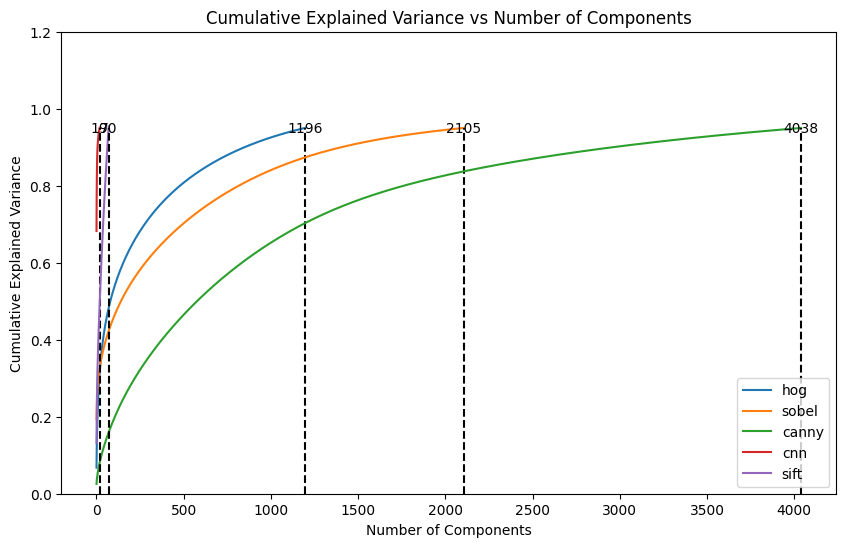

In [ ]:
plot_explained_variance(results, variance)

## tSNE plot: train data

In [ ]:
#load scaled features of train data
f_hog = pickle.load(open(feature_path + '/train_hog_std.pkl', 'rb'))
f_sift = pickle.load(open(feature_path + '/train_sift_std.pkl', 'rb'))
f_cnn = pickle.load(open(feature_path + '/train_cnn_std.pkl', 'rb'))
f_canny = pickle.load(open(feature_path + '/train_canny_std.pkl', 'rb'))
f_sobel = pickle.load(open(feature_path + '/train_sobel_std.pkl', 'rb'))

#get scaled features image id of train data from one of the dictionary
df_img_id = pd.DataFrame(list(f_hog.keys()), columns=['image'])

#change features into arrays
f_hog = np.array(list(f_hog.values()))
f_sift = np.array(list(f_sift.values()))
f_cnn = np.array(list(f_cnn.values()))
f_canny = np.array(list(f_canny.values()))
f_sobel = np.array(list(f_sobel.values()))


#check shape
print("Image ID: ", df_img_id.shape)
print("HOG features: ", f_hog.shape)
print("SIFT features: ", f_sift.shape)
print("CNN features: ", f_cnn.shape)
print("CANNY features: ", f_canny.shape)
print("SOBEL features: ", f_sobel.shape)

Image ID:  (6254, 1)
HOG features:  (6254, 14688)
SIFT features:  (6254, 79)
CNN features:  (6254, 2048)
CANNY features:  (6254, 27648)
SOBEL features:  (6254, 27648)


In [ ]:
#get train data labels
df_train_label = pickle.load(open(output_path+'/train_label.pkl', 'rb'))
df_train_label.head(1)

,label,group
image,,
N25_100EK113_03030540.JPG,Peccary,Peccary-398d85ab-7160-11ec-898c-5cf3706028c2


In [ ]:
#join df_img_id with df_train_label to get correct order of y
y = df_img_id.merge(df_train_label, on = 'image', how='left')

In [ ]:
# Apply t-SNE to the concatenated training feature matrix
X_hog_tsne, X_sobel_tsne, X_canny_tsne, X_sift_tsne, X_cnn_tsne  = get_tsne([f_hog, f_sobel, f_canny, f_sift, f_cnn], n_components=2)

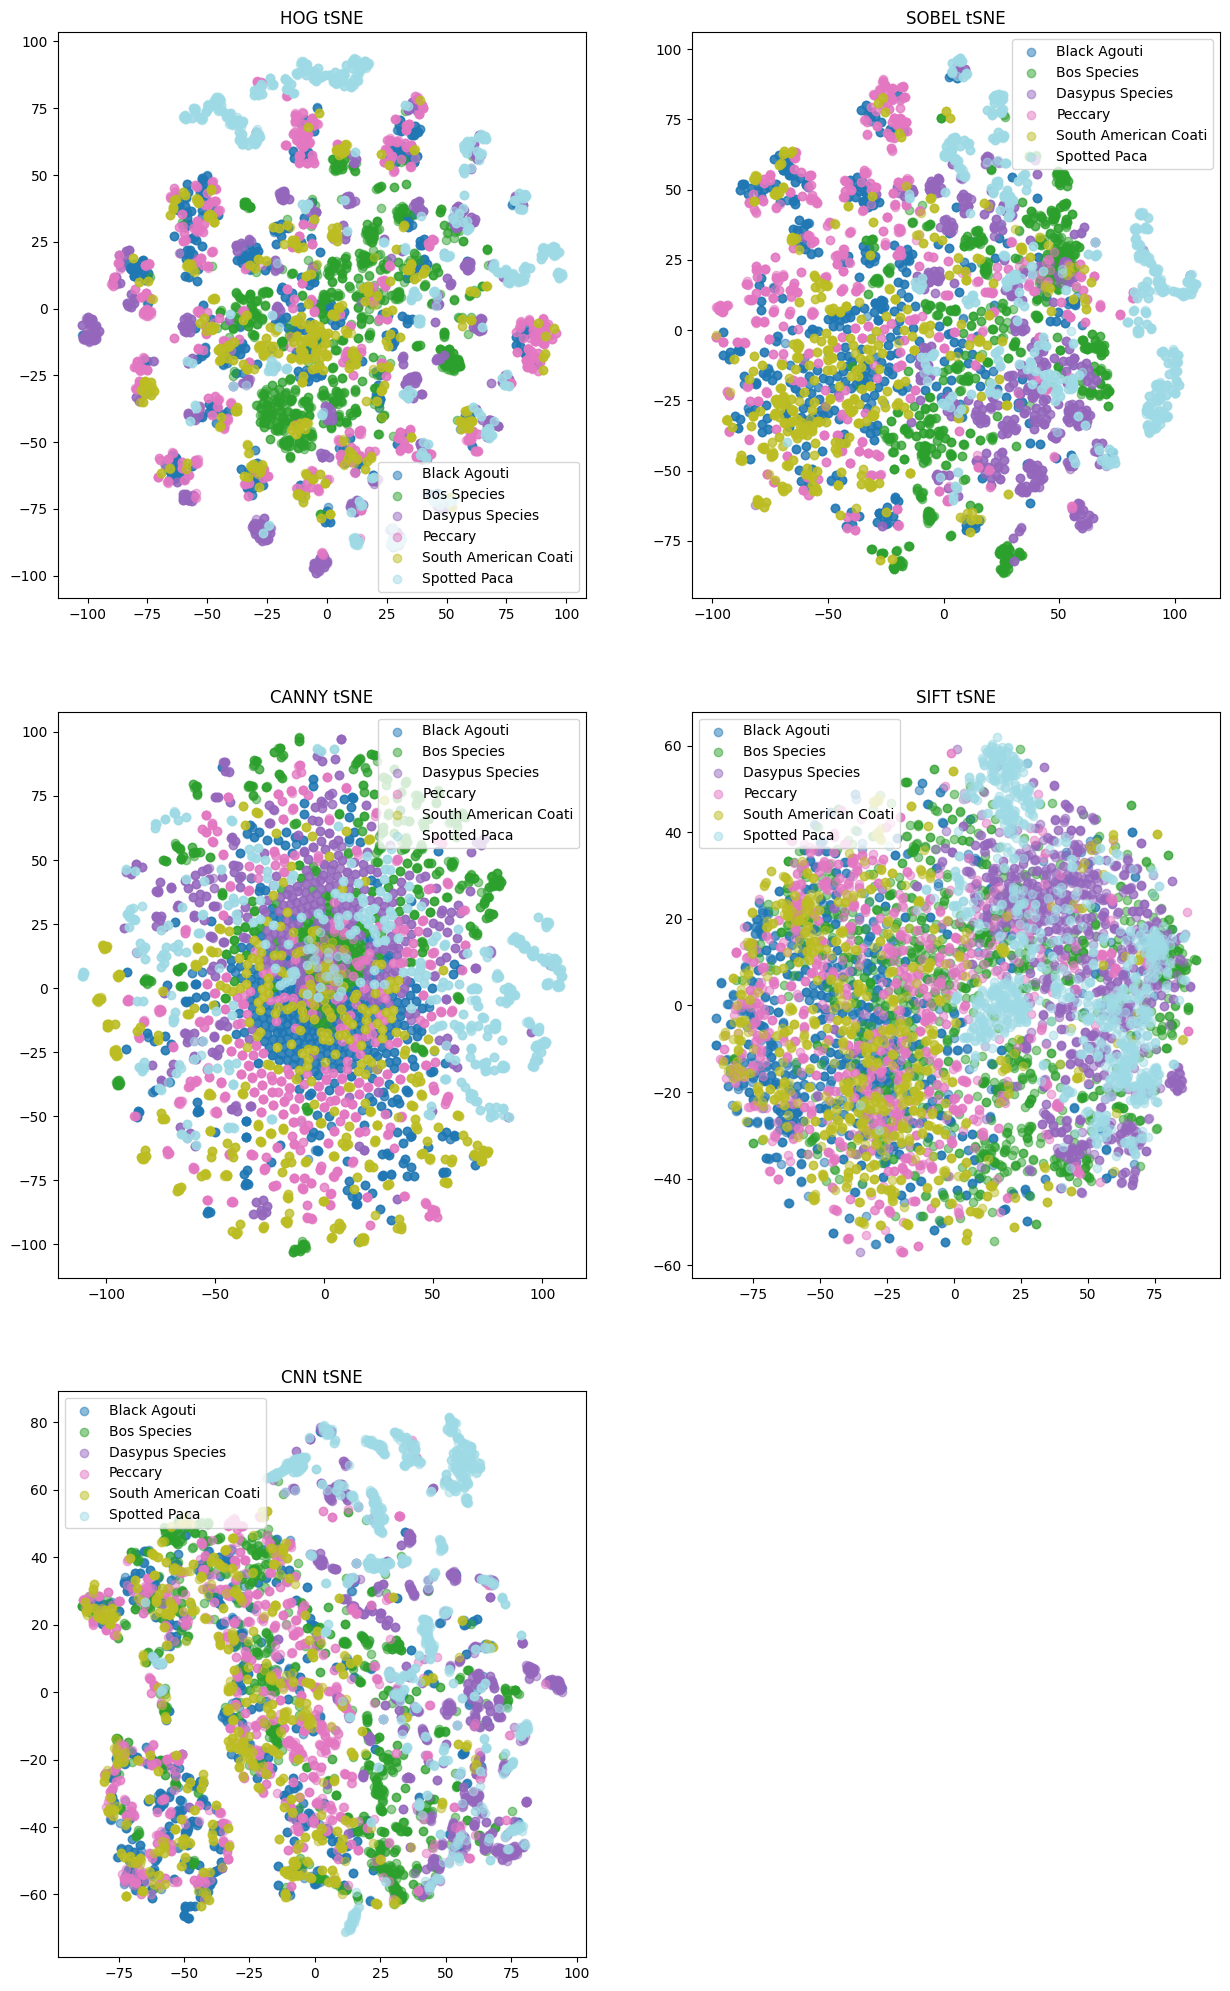

In [ ]:
# plot tsne results
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(15,25))

# y is the class labels
plot_classes(X_hog_tsne, y['label'], ax[0,0], title='HOG tSNE')
plot_classes(X_sobel_tsne, y['label'], ax[0,1], title='SOBEL tSNE')
plot_classes(X_canny_tsne, y['label'], ax[1,0], title='CANNY tSNE')
plot_classes(X_sift_tsne, y['label'], ax[1,1], title='SIFT tSNE')
plot_classes(X_cnn_tsne, y['label'], ax[2,0], title='CNN tSNE')
ax[2,1].axis('off')
plt.show()